### Data extraction
Extract data from MIMIC-III

In [1]:
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cufflinks

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
# Import pandas 
import pandas as pd 

start = time.time()
# reading csv file 
admissions_df = pd.read_csv("../../MIMIC-III//ADMISSIONS.csv")
noteevents_df = pd.read_csv("../../MIMIC-III//NOTEEVENTS.csv") 
end = time.time()
print(end - start)


/data/home/evgenii/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



39.090027809143066


In [3]:
start = time.time()
# Left join of two dataframes
note_admiss_df_left = noteevents_df.merge(admissions_df, on='HADM_ID', how='left', indicator=True)
end = time.time()
print(end - start)

4.577013731002808


In [4]:
note_admiss_df_left[['DIAGNOSIS', 'SUBJECT_ID_x', 'SUBJECT_ID_y','DESCRIPTION', 'CATEGORY']]

,DIAGNOSIS,SUBJECT_ID_x,SUBJECT_ID_y,DESCRIPTION,CATEGORY
0,RT LOWER LOBE PNEUMONIA,22532,22532.0,Report,Discharge summary
1,CHRONIC OBSTRUCTIVE PULMONARY DISEASE,13702,13702.0,Report,Discharge summary
2,TRACHEALBRONCHEAL MALACEA/SDA,13702,13702.0,Report,Discharge summary
3,ASTHMA;COPD EXACERBATION,13702,13702.0,Report,Discharge summary
4,S/P FALL;TELEMETRY,26880,26880.0,Report,Discharge summary
...,...,...,...,...,...
2083175,NEWBORN,31097,31097.0,Report,Nursing/other
2083176,NEWBORN,31097,31097.0,Report,Nursing/other
2083177,NEWBORN,31097,31097.0,Report,Nursing/other
2083178,NEWBORN,31097,31097.0,Report,Nursing/other


In [5]:
pneumonia_df = note_admiss_df_left.loc[note_admiss_df_left["DIAGNOSIS"] == 'PNEUMONIA', ['ROW_ID_x', 'SUBJECT_ID_x', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA']]

In [6]:
#pneumonia_no_disch_df = pneumonia_df.loc[pneumonia_df["CATEGORY"] != 'Discharge summary', ['ROW_ID_x', 'SUBJECT_ID_x', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA']]
pneumonia_no_disch_df = pneumonia_df.loc[pneumonia_df["CATEGORY"] != 'Discharge summary', ['ROW_ID_x','SUBJECT_ID_x','CHARTDATE','STORETIME','CATEGORY','DESCRIPTION','TEXT', 'DEATHTIME']]

In [7]:
pneumonia_alive_no_disch = pneumonia_no_disch_df[pneumonia_no_disch_df.DEATHTIME.isnull()]
pneumonia_dead_no_disch = pneumonia_no_disch_df[pneumonia_no_disch_df.DEATHTIME.notnull()]

In [8]:
pneumonia_dead_no_disch.shape

(11895, 8)

In [9]:
pneumonia_alive_no_disch.shape

(46134, 8)

In [10]:
pneumonia_alive_no_disch = pneumonia_alive_no_disch.sort_values(by=['SUBJECT_ID_x','CHARTDATE', 'ROW_ID_x'])
pneumonia_dead_no_disch = pneumonia_dead_no_disch.sort_values(by=['SUBJECT_ID_x','CHARTDATE', 'ROW_ID_x'])

In [11]:
# Number of patients
pneumonia_dead_no_disch['SUBJECT_ID_x'].nunique()

252

In [12]:
# Number of patients
pneumonia_alive_no_disch['SUBJECT_ID_x'].nunique()

1167

In [13]:
# import text handling tool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from collections import Counter

import sys
import re
import csv
import os.path

# define constants
# RESULT_HEADER = "WORD, FREQUENCY\n"
MIN_SEQ_LEN = 4
USE_1_N_SEQ = 2


# words that do not have meaning (can be modified later)
USELESS_WORDS = ["a", "the", "he", "she", ",", ".", "?", "!", ":", ";", "+", "*", "**"\
                 "your", "you"]

# count up the frequency of every word in every disease file
stemmer = PorterStemmer()
# create set of words to ignore in text
stop_words = set(stopwords.words('english'))

for word in USELESS_WORDS:
    stop_words.add(word)

In [14]:

#----------
def count_notes_per_patient(disease_df):
    patient_id_to_num_notes = {}
    patient_id = -1
    note_counter = 0
            
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        patient_id_check = int(row['SUBJECT_ID_x'])
                
        if not patient_id == patient_id_check:
            patient_id_to_num_notes[patient_id] = note_counter
            note_counter = 1
        else:
            note_counter += 1
                    
        patient_id = patient_id_check
                
    patient_id_to_num_notes[patient_id] = note_counter
    del patient_id_to_num_notes[-1]
    return patient_id_to_num_notes

patient_id_to_num_notes = {}
patient_id_to_num_notes['pneumonia_dead'] = count_notes_per_patient(pneumonia_dead_no_disch)
patient_id_to_num_notes['pneumonia_alive'] = count_notes_per_patient(pneumonia_alive_no_disch)

100%|██████████| 46134/46134 [00:04<00:00, 9240.62it/s]


In [15]:
def count_words_per_patient(disease_df, patient_id_to_num_notes):
    note_appearance_counter = {}
    number_of_patients = 0 # number of patients
    note_counter = 0

# -----------
    patient_id = -1
    word_set = set()
    note_event_counter = 0

    # Iterate through each note
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):

        
        patient_id_check = int(row['SUBJECT_ID_x'])
    
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check:
            number_of_patients += 1
            note_event_counter = 0
        
            for word in word_set:
                if word in note_appearance_counter:
                    note_appearance_counter[word] += 1
                else:
                    note_appearance_counter[word] = 1

        
            # reset word_set
            word_set = set()
        
        # update patient id
        patient_id = patient_id_check

            
        if patient_id_to_num_notes[patient_id_check] <= MIN_SEQ_LEN:
            continue
            
        if note_event_counter < patient_id_to_num_notes[patient_id] // USE_1_N_SEQ:
            note_event_counter += 1
            continue
                
        note_counter += 1
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        tokenized_note = word_tokenize(note)
        
        
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())
            if not stemmed_word in stop_words:
                word_set.add(stemmed_word)
    
    print(str(note_counter) + " note events")
    print("finished counting frequent words for patients!")
#     return note_counter, note_appearance_counter
    return number_of_patients, note_appearance_counter

# variable dictionaries
number_of_notes = {}
note_appearance_counter = {}

number_of_notes['pneumonia_dead'], note_appearance_counter['pneumonia_dead'] = count_words_per_patient(pneumonia_dead_no_disch, patient_id_to_num_notes['pneumonia_dead'])
number_of_notes['pneumonia_alive'], note_appearance_counter['pneumonia_alive'] = count_words_per_patient(pneumonia_alive_no_disch, patient_id_to_num_notes['pneumonia_alive'])

  0%|          | 1/46134 [00:00<1:33:41,  8.21it/s]

5989 note events
finished counting frequent words for patients!


100%|██████████| 46134/46134 [03:01<00:00, 254.66it/s]

23172 note events
finished counting frequent words for patients!


In [16]:
# # get hyper-paramters n_fold and threshold from user input
n_fold = float(3)
threshold = float(0.01)

frequent_word_lists = {}
factor = {}

In [17]:
"""function description:
for each disease in note_appearance_counter
    1. checks whether a word in disease file is frequent(frequency standard as defined by factor, n_fold, and threshold)
    2. adds to frequent_word_list
"""

# def find_frequent_word(note_appearance_counter, frequent_word_lists, number_of_notes, factor, n_fold, threshold):

# calculate normalizing factor for each disease
note_sum = 0

# Count from two labels
for disease in number_of_notes:
    note_sum += float(number_of_notes[disease])
    
for disease in number_of_notes:
    factor[disease] = number_of_notes[disease] / note_sum

# determine frequent word for each disease file
for disease in note_appearance_counter:
    frequent_word_lists[disease] = []

    print(disease + " has " + str(len(note_appearance_counter[disease])) + " unique words!")

    for word in note_appearance_counter[disease]:
        
        freq_check = True
        for check_disease in note_appearance_counter:
            
            if not disease == check_disease:
                if word in note_appearance_counter[check_disease]:
                    if not (note_appearance_counter[disease][word] / note_appearance_counter[check_disease][word] / factor[disease] * factor[check_disease] > n_fold \
                        and note_appearance_counter[disease][word] > (number_of_notes[disease] * threshold)):

                        freq_check = False
                        break

                else:
                    if not (note_appearance_counter[disease][word] > n_fold and note_appearance_counter[disease][word] > (number_of_notes[disease] * threshold)):
                        freq_check = False
                        break
        if freq_check:
            frequent_word_lists[disease].append((word))
            # Create a tuple of word and its count
#             frequent_word_lists[disease].append((word, note_appearance_counter[disease][word]))

        

print("finished making frequent words list for " + disease)

pneumonia_dead has 11678 unique words!
pneumonia_alive has 22572 unique words!
finished making frequent words list for pneumonia_alive


In [18]:
print(len(frequent_word_lists['pneumonia_dead']))
print(len(frequent_word_lists['pneumonia_alive']))

454
329


### 2. Co-occurrence generation

In [19]:
FREQUENT_WORD_LIST = frequent_word_lists['pneumonia_dead'] + frequent_word_lists['pneumonia_alive']
print(len(FREQUENT_WORD_LIST))
print(len(set(FREQUENT_WORD_LIST)))

783
783


In [20]:
"""function description:
generates frequent word set for the disease
"""
word_dict = {}
word_id = 1
stemmer = PorterStemmer()


for word in FREQUENT_WORD_LIST:
    if not word == "WORD":
        word_dict[stemmer.stem(word.strip())] = word_id
        word_id += 1
             
print(f"\nword dictionary created! Length: {len(word_dict)}\n")
print(word_dict)


word dictionary created! Length: 783

{'cremat': 1, 'mottl': 2, 'unrespon': 3, 'arrest': 4, 'vasopressin': 5, 'hypothermia': 6, 'autopeep': 7, 'dic': 8, 'anur': 9, 'hypercapnia': 10, 'pcv': 11, 'arrang': 12, 'clinician': 13, 'azotemia': 14, 'park': 15, 'expir': 16, 'refractori': 17, 'hypercapn': 18, 'funer': 19, 'pea': 20, 'paralyt': 21, 'clergi': 22, 'cpr': 23, 'elig': 24, 'bicarbon': 25, 'death': 26, 'norepinephrin': 27, 'acidem': 28, 'suffer': 29, 'recruit': 30, 'profound': 31, 'phenylephrin': 32, 'virtual': 33, 'slough': 34, 'nonpurpo': 35, 'gum': 36, 'sluggish': 37, 'dk': 38, 'dni': 39, 'dnr': 40, 'lubric': 41, 'cmo': 42, 'nacl': 43, 'pinpoint': 44, 'oder': 45, 'float': 46, 'mso': 47, 'levoph': 48, 'clariti': 49, 'wish': 50, 'suport': 51, 'institut': 52, 'remin': 53, 'dead': 54, 'antb': 55, 'hypot': 56, 'peerla': 57, 'bow': 58, 'purpl': 59, 'gather': 60, 'viabl': 61, 'option': 62, 'priest': 63, 'grim': 64, 'dd': 65, 'prognosi': 66, 'pronounc': 67, 'respon': 68, 'centimet': 69, 'b

### Count co-occurrences per patient

In [21]:


# Comparison algorithms
# Apriori, Fpgrowth, fp_max

# Apriori
import pandas as pd

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

# ----
def apr_patterns_per_patient_python(disease_df, min_support):
    
    # For dataframe
    patient_cooc_dict = {}
    patient_node_dict = {}
    patient_note_cnt = {}
    patient_itemset_dict = {}
    
    # --------------    
    patient_id = -1
    note_cnt = 0
    patient_note_list = []
    
    # read line in from file (each line is one note)
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        
        # only regard certain type of notes
        patient_id_check = int(row['SUBJECT_ID_x'])
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        patient_word_set = set()
    
#         print(f"patient_id_check: {patient_id_check}, patient_id: {patient_id}")
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check and not patient_id == -1:
            te = TransactionEncoder()
            te_ary = te.fit(patient_note_list).transform(patient_note_list)
            df = pd.DataFrame(te_ary, columns=te.columns_)
            df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
            cooc_tmp = []
            cooc_minsup_tmp = []
            node_minsup_tmp = []
            cooc_node_idx_tmp = []
            itemsets_tmp = []
            
            for index, row in df_itemsets.iterrows():
                if len(row['itemsets']) == 1:
                    word = list(row['itemsets'])[0]
                    min_sup = row['support']

                    node_minsup_tmp.append(len(patient_note_list) * row['support'])
                    cooc_node_idx_tmp.append(word)
                    
                if len(row['itemsets']) == 2:
                    cooc_ = sorted(list(row['itemsets']))
                    cooc_tmp.append(cooc_)
                    cooc_minsup_tmp.append(len(patient_note_list) * row['support'])

                if len(row['itemsets']) >= 2:
                    itemset = sorted(list(row['itemsets']))
                    itemsets_tmp.append(itemset)
                    
            
            cooc_dict = {}

            for num, i in enumerate(cooc_tmp):
                if tuple(i) not in cooc_dict:
                    cooc_dict[tuple(i)] = cooc_minsup_tmp[num]


            node_dict = {}
            for num, i in enumerate(cooc_node_idx_tmp):
                if i not in node_dict:
                    node_dict[i] = node_minsup_tmp[num]

            # Update glob lists
            if patient_id not in patient_cooc_dict:
                patient_cooc_dict[patient_id] = cooc_dict
                patient_node_dict[patient_id] = node_dict
                patient_note_cnt[patient_id] = note_cnt
                patient_itemset_dict[patient_id] = itemsets_tmp
    
            else:
                print(f"patient_id: {patient_id} is already in the dictionary!")
            
            
            # Reset local lists
            patient_note_list = []
            note_cnt = 0
                    
        # update patient id
        patient_id = patient_id_check
        tokenized_note = word_tokenize(note)
        note_cnt += 1

        # loop through each word in note to count word belonging to each disease
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())       
            if stemmed_word in word_dict:
                patient_word_set.add(stemmed_word)

        templst = []
        for word in patient_word_set:
            templst.append(word)

        if templst:
            patient_note_list.append(templst)
    
    # Last patient info
    te = TransactionEncoder()
    te_ary = te.fit(patient_note_list).transform(patient_note_list)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
    cooc_tmp = []
    cooc_minsup_tmp = []
    #-----
    node_minsup_tmp = []
    cooc_node_idx_tmp = []
    itemsets_tmp = []
            
    for index, row in df_itemsets.iterrows():
        if len(row['itemsets']) == 1:
            word = list(row['itemsets'])[0]
            node_minsup_tmp.append(len(patient_note_list) * row['support'])
            cooc_node_idx_tmp.append(word)

        if len(row['itemsets']) == 2:
            cooc_ = sorted(list(row['itemsets']))
            cooc_tmp.append(cooc_)
            cooc_minsup_tmp.append(len(patient_note_list) * row['support'])

        if len(row['itemsets']) >= 2:
            itemset = sorted(list(row['itemsets']))
            itemsets_tmp.append(itemset)

    cooc_dict = {}

    for num, i in enumerate(cooc_tmp):
        if tuple(i) not in cooc_dict:
            cooc_dict[tuple(i)] = cooc_minsup_tmp[num]


    node_dict = {}
    for num, i in enumerate(cooc_node_idx_tmp):
        if i not in node_dict:
            node_dict[i] = node_minsup_tmp[num]
    
                

    # Update glob lists
    if patient_id not in patient_cooc_dict:
        patient_cooc_dict[patient_id] = cooc_dict
        patient_node_dict[patient_id] = node_dict
        patient_note_cnt[patient_id] = note_cnt
        patient_itemset_dict[patient_id] = itemsets_tmp
    else:
        print(f"patient_id: {patient_id} is already in the dictionary!")

    return patient_node_dict, patient_cooc_dict, patient_itemset_dict, patient_note_cnt

apr_patient_node_0, apr_patient_cooc_0, apr_patient_itemset_0, apr_patient_note_num_0 = apr_patterns_per_patient_python(pneumonia_dead_no_disch, 0.15)
apr_patient_node_1, apr_patient_cooc_1, apr_patient_itemset_1, apr_patient_note_num_1 = apr_patterns_per_patient_python(pneumonia_alive_no_disch, 0.15)

100%|██████████| 46134/46134 [06:36<00:00, 116.41it/s]


In [22]:
# Create a set of all unique co-occurrences from both group
patient_cooc_set = set()
patient_cooc_0_dict = {}
patient_cooc_1_dict = {}

for k, v in apr_patient_cooc_0.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_0_dict:
            patient_cooc_0_dict[item] = v[item]
        else:
            patient_cooc_0_dict[item] = patient_cooc_0_dict[item] + v[item]
            
    
for k, v in apr_patient_cooc_1.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_1_dict:
            patient_cooc_1_dict[item] = v[item]
        else:
            patient_cooc_1_dict[item] = patient_cooc_1_dict[item] + v[item]

In [23]:
print(len(patient_cooc_set))
print(len(patient_cooc_0_dict))
print(len(patient_cooc_1_dict))

6776
1989
5152


In [24]:
import math
patient_cooc_odd_scores = {}
for set_item in patient_cooc_set:
    if set_item in patient_cooc_0_dict and set_item in patient_cooc_1_dict: 
        d_prob = patient_cooc_0_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        a_prob = patient_cooc_1_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score

In [25]:
patient_cooc_odd_scores

{('dnr', 'requr'): -1.7859498421315991,
 ('ambul', 'eyelid'): -6.90875477931522,
 ('breakfast', 'panic'): 6.90875477931522,
 ('ba', 'opiat'): 6.90875477931522,
 ('hive', 'oncologist'): -1.0473214909132258,
 ('qtc', 'venti'): 6.90875477931522,
 ('mrcp', 'wma'): -6.90875477931522,
 ('nonlabor', 'oob'): 6.90875477931522,
 ('oximetri', 'rigor'): 6.90875477931522,
 ('laminectomi', 'mellitu'): 6.90875477931522,
 ('captopril', 'proph'): 6.90875477931522,
 ('ppd', 'unstabl'): 6.90875477931522,
 ('ruptur', 'sibl'): 6.90875477931522,
 ('vasopressin', 'wma'): -6.90875477931522,
 ('phenylephrin', 'seat'): 6.90875477931522,
 ('echocardiogram', 'sweat'): 6.90875477931522,
 ('aliv', 'sweat'): 6.90875477931522,
 ('angiogram', 'hemangioma'): 6.90875477931522,
 ('bair', 'deterior'): 6.90875477931522,
 ('opiat', 'pharyng'): 6.90875477931522,
 ('subq', 'thiamin'): 6.90875477931522,
 ('hung', 'life'): -6.90875477931522,
 ('dni', 'iddm'): 6.90875477931522,
 ('chair', 'levoph'): 6.90875477931522,
 ('dex', 'n

In [26]:
# Data normalization
import numpy
def data_norm(cooc_odd_scores):

    def norm_arr(array):
        arr = numpy.array(list(array))
        start = 0
        end = 1
        width = end - start
        res = (arr - arr.min())/(arr.max() - arr.min()) * width + start
        return res.tolist()

    cooc_keys, cooc_values = zip(*cooc_odd_scores.items())
    new_cooc_odd_scores = dict(zip(cooc_keys, norm_arr(cooc_values)))

    return new_cooc_odd_scores

new_patient_cooc_odd_scores = data_norm(patient_cooc_odd_scores)

In [27]:
# Additional code to label node words
apr_patient_node_set = set()
apr_patient_node_0_dict = {}
apr_patient_node_1_dict = {}
    
for k, v in apr_patient_node_0.items():
    for item in v:
        apr_patient_node_set.add(item)
        
        if item not in apr_patient_node_0_dict:
            apr_patient_node_0_dict[item] = v[item]
        else:
            apr_patient_node_0_dict[item] = apr_patient_node_0_dict[item] + v[item]
        
    
for k, v in apr_patient_node_1.items():
    for item in v:
        apr_patient_node_set.add(item)
        
        if item not in apr_patient_node_1_dict:
            apr_patient_node_1_dict[item] = v[item]
        else:
            apr_patient_node_1_dict[item] = apr_patient_node_1_dict[item] + v[item]

In [28]:
print(len(apr_patient_node_set))
print(len(apr_patient_node_0_dict))
print(len(apr_patient_node_1_dict))

633
379
571


In [29]:
apr_patient_node_odd_scores = {}

for set_item in apr_patient_node_set:
    if set_item in apr_patient_node_0_dict and set_item in apr_patient_node_1_dict:
        d_prob = apr_patient_node_0_dict[set_item]/(apr_patient_node_0_dict[set_item] + apr_patient_node_1_dict[set_item])
        a_prob = apr_patient_node_1_dict[set_item]/(apr_patient_node_0_dict[set_item] + apr_patient_node_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        apr_patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in apr_patient_node_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        apr_patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in apr_patient_node_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        apr_patient_node_odd_scores[set_item] = log_odd_score

In [30]:
print(apr_patient_node_odd_scores)

{'readmit': 6.90875477931522, 'suport': -6.90875477931522, 'permiss': -2.1883847407670785, 'goc': 0.3357879300251662, 'gait': 2.601472222000523, 'institut': 2.007571633726069, 'sensat': 3.269258198656955, 'solut': 6.90875477931522, 'ud': 6.90875477931522, 'emper': 6.90875477931522, 'grave': -0.4046335072286383, 'calculi': 1.5360079185039965, 'declin': -0.3251358805203766, 'consciou': 6.90875477931522, 'ba': 6.90875477931522, 'rsrc': 6.90875477931522, 'para': 3.464102558012661, 'pneumococc': 2.221693083087361, 'chb': 0.6077720443224599, 'habitu': 3.4292390061376663, 'knowledg': 6.90875477931522, 'spfc': 2.0716061679700735, 'mail': 6.90875477931522, 'currenlti': 6.90875477931522, 'futil': -1.7859498421315991, 'precordium': 1.604655121332035, 'venti': 1.2552344413016325, 'hung': -1.095952712632351, 'intent': 6.90875477931522, 'mottl': 1.5488483166697078, 'proph': 6.90875477931522, 'passi': 6.90875477931522, 'impli': 0.6916505477038827, 'viscou': 6.90875477931522, 'unrel': -0.4046335072286

In [31]:
apr_patient_square_node_data = pd.DataFrame({'node':list(apr_patient_node_odd_scores.keys()), 'feature':list(apr_patient_node_odd_scores.values())})
apr_patient_square_node_data

,node,feature
0,readmit,6.908755
1,suport,-6.908755
2,permiss,-2.188385
3,goc,0.335788
4,gait,2.601472
...,...,...
628,spectral,0.978543
629,abruptli,-6.908755
630,aglc,6.908755
631,signatur,2.601472


In [32]:
apr_patient_square_node_id_data = apr_patient_square_node_data.set_index("node")
apr_patient_square_node_id_data['subject'] = ["positive" if r['feature'] > 0 else "negative" for i, r in apr_patient_square_node_id_data.iterrows()]
apr_patient_square_node_id_data

,feature,subject
node,,
readmit,6.908755,positive
suport,-6.908755,negative
permiss,-2.188385,negative
goc,0.335788,positive
gait,2.601472,positive
...,...,...
spectral,0.978543,positive
abruptli,-6.908755,negative
aglc,6.908755,positive


In [33]:
apr_subjects = apr_patient_square_node_id_data["subject"]
apr_subjects

node
readmit      positive
suport       negative
permiss      negative
goc          positive
gait         positive
               ...   
spectral     positive
abruptli     negative
aglc         positive
signatur     positive
captopril    positive
Name: subject, Length: 633, dtype: object

In [34]:
# Create a list of all itemsets
apr_itemsets = []

for k,v in tqdm(apr_patient_itemset_0.items()):
    
    for i in v:  
        if i not in apr_itemsets:
            apr_itemsets.append(i)
    
for k,v in tqdm(apr_patient_itemset_1.items()):
    for i in v:
        if i not in apr_itemsets:
            apr_itemsets.append(i)

100%|██████████| 1167/1167 [14:18<00:00,  1.36it/s]   


In [35]:
print(len(apr_itemsets))

293768


In [36]:
print(apr_itemsets[:100])

[['arrest', 'pea'], ['cpr', 'pea'], ['arrest', 'cpr'], ['arrest', 'cpr', 'pea'], ['cpr', 'vasopressin'], ['pea', 'vasopressin'], ['arrest', 'vasopressin'], ['cpr', 'pea', 'vasopressin'], ['arrest', 'cpr', 'vasopressin'], ['arrest', 'pea', 'vasopressin'], ['arrest', 'cpr', 'pea', 'vasopressin'], ['pcv', 'vasopressin'], ['cpr', 'pcv'], ['pcv', 'pea'], ['arrest', 'pcv'], ['cpr', 'pcv', 'vasopressin'], ['pcv', 'pea', 'vasopressin'], ['arrest', 'pcv', 'vasopressin'], ['cpr', 'pcv', 'pea'], ['arrest', 'cpr', 'pcv'], ['arrest', 'pcv', 'pea'], ['cpr', 'pcv', 'pea', 'vasopressin'], ['arrest', 'cpr', 'pcv', 'vasopressin'], ['arrest', 'pcv', 'pea', 'vasopressin'], ['arrest', 'cpr', 'pcv', 'pea'], ['arrest', 'cpr', 'pcv', 'pea', 'vasopressin'], ['paralyt', 'pcv'], ['paralyt', 'vasopressin'], ['cpr', 'paralyt'], ['paralyt', 'pea'], ['arrest', 'paralyt'], ['paralyt', 'pcv', 'vasopressin'], ['cpr', 'paralyt', 'pcv'], ['paralyt', 'pcv', 'pea'], ['arrest', 'paralyt', 'pcv'], ['cpr', 'paralyt', 'vasopre

#### Create embeddings from apr_cooc

In [37]:
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

In [38]:
apr_cooc_model_patient = Word2Vec(
    apr_itemsets, size=128, window=5, min_count=0, sg=1, workers=4, iter=1
)

In [39]:
emb = apr_cooc_model_patient.wv["cmo"]
emb

array([ 0.1881582 , -0.19139174,  0.21390189,  0.3292663 , -0.09690257,
       -0.24458025,  0.01753123, -0.19995943, -0.29192448,  0.06493586,
       -0.24985106,  0.06104916, -0.0281712 , -0.3158754 , -0.1182294 ,
       -0.10239854,  0.5869148 ,  0.19746985,  0.12057449, -0.15345098,
        0.09018557, -0.5810651 ,  0.19828169, -0.15030856, -0.2116011 ,
       -0.16286957, -0.14880285, -0.4191259 , -0.07995562, -0.06796566,
       -0.01030982, -0.08070359,  0.3301768 ,  0.25098333, -0.14868994,
       -0.2170262 , -0.12274618, -0.3865495 , -0.31485012, -0.18553753,
       -0.13808224, -0.22749841,  0.2884389 , -0.2249022 ,  0.10250145,
        0.3517282 ,  0.30275247, -0.03127793,  0.15640816,  0.3408232 ,
       -0.11753867,  0.10560799, -0.4612614 ,  0.05049331, -0.1331845 ,
       -0.22877333,  0.1761968 ,  0.27193442, -0.08689488,  0.20317881,
        0.22739604,  0.07450799,  0.02595266, -0.0341915 ,  0.04971341,
        0.24475703,  0.37543276, -0.31138864, -0.0106193 , -0.19

#### Visualise node embeddings for apr_cooc

In [40]:
# Retrieve node embeddings and corresponding subjects
patient_node_ids = apr_cooc_model_patient.wv.index2word  # list of node IDs
patient_weighted_node_embeddings = (
    apr_cooc_model_patient.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
patient_node_targets = apr_subjects.loc[patient_node_ids].astype("category")

In [41]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
patient_weighted_node_embeddings_2d = tsne.fit_transform(patient_weighted_node_embeddings)

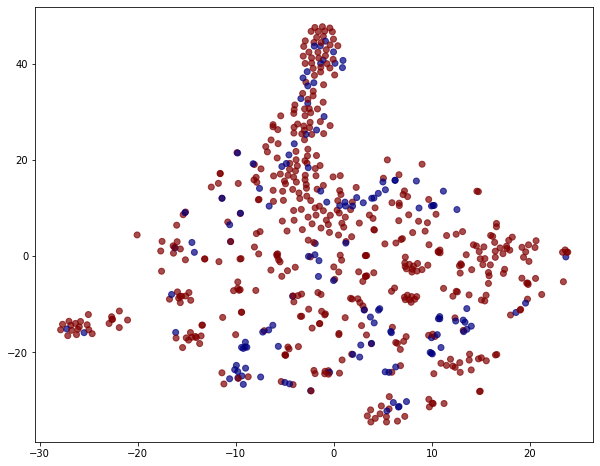

In [42]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    patient_weighted_node_embeddings_2d[:, 0],
    patient_weighted_node_embeddings_2d[:, 1],
    c=patient_node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [43]:
# Create a random vector for words that are not in a dictionary
apr_node_emb_dict = {}
rand_vec_cnt = 0
for index, row in apr_patient_square_node_id_data.iterrows():
    try:
        if index not in apr_node_emb_dict:
            apr_node_emb_dict[index] = apr_cooc_model_patient.wv[index]
        else:
            print(f"index: {index} is already in a dictionary!")
    except KeyError:
        rand_vec_cnt += 1
        apr_node_emb_dict[index] = np.random.normal(scale=0.6, size=128)

print(f"random vector counter is {rand_vec_cnt}")

random vector counter is 26


### Load the data

In [44]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 42
numpy.random.seed(seed)
tf.random.set_seed(seed)
sg.random.set_seed(seed)

#### Train apr

In [45]:
from collections import defaultdict

def create_apr_graph_list(patient_cooc_dict, cooc_odd_scores, node_emb_dict, label):
    
    graphs = []
    labels = []
    
    for key,row in patient_cooc_dict.items():
     
        if row:
            source = []
            target = []
            # edge_weight = []
            
            node_feature = []
            node_idx = []
            for cooc in row:
                source.extend([cooc[0], cooc[1]])
                target.extend([cooc[1], cooc[0]])
                # edge_weight.extend([cooc_odd_scores[cooc], cooc_odd_scores[cooc]])
        
            node_idx = list(set(source + target))
    
            # Create a dataframe of only nodes
            square_node_data = pd.DataFrame(
                index=node_idx)
            
#             square_node_data['feature'] = [1] * len(node_idx)
            
            # Create a dictionary for each column for a vector
            node_features = defaultdict(list)
            for node in node_idx:
                for i, vec in enumerate(node_emb_dict[node]):
                    node_features['w_' + str(i)].append(vec)
        
            # Add columns to a dataframe
            for k, v in node_features.items():
              
                square_node_data[k] = v

            square_edges = pd.DataFrame({ 
                "source": source, 
                "target": target, 
                # "weight":edge_weight
            })
        
            square = StellarGraph({"corner": square_node_data}, {"line": square_edges})
            graphs.append(square)
            labels.append(label)
            
    return graphs, labels

graphs = []
labels = []

# patient_weighted_node_emb_dict
graph_0, label_0 = create_apr_graph_list(apr_patient_cooc_0, new_patient_cooc_odd_scores, apr_node_emb_dict, -1)
graph_1, label_1 = create_apr_graph_list(apr_patient_cooc_1, new_patient_cooc_odd_scores, apr_node_emb_dict, 1)

graphs.extend(graph_0)
labels.extend(label_0)
print(f"graphs_0: {len(graphs)}, labels_0: {len(labels)}")
graphs.extend(graph_1)
labels.extend(label_1)
print(f"graphs_1: {len(graph_1)}, labels_1: {len(label_1)}")
print(f"graphs: {len(graphs)}, labels: {len(labels)}")

graphs_0: 162, labels_0: 162
graphs_1: 726, labels_1: 726
graphs: 888, labels: 888


In [46]:
# prepare test and train datasets
test_cnt = int(len(graphs)*0.1)/2
print(test_cnt)

pos_start = len(graph_0)
print(pos_start)

test_arr = []
train_arr = []
for i, v in enumerate(graphs):
    # Take first items for neg set
    if i < test_cnt:
        test_arr.append(i)    
    elif i > pos_start and i <= pos_start + test_cnt:
        test_arr.append(i)    
    else:
        train_arr.append(i)

44.0
162


In [47]:
import random
seed = 42
c = list(test_arr)
random.Random(seed).shuffle(c)
test_arr =  c

In [48]:
c = list(train_arr)
random.Random(seed).shuffle(c)
train_arr =  c

In [49]:
train_index = np.array(train_arr)
test_index = np.array(test_arr)

In [50]:
print(len(test_index))
print(test_index)

88
[178 182  33  30  19  26 165 187  15 185  42   1 195 179 175  37 186  36
 171 164 192  20 202   8  41 198  40 177  32 174  39 205  43 196  12  23
  18 189 169 168   7  34 190   2  16  38 166  22 180  24   5   6 184 181
 199   9 206  21 191 163  10 170 167   0 203 176 201 172  25 193 183  29
  27 197 204   4 173 194  11 188  13  17  28  31  35   3  14 200]


In [51]:
print(len(train_index))
print(train_index)

800
[820 462 661 578 735 619 446 737 538 861 583 732 876 425  68 879 265 466
 428 149 486 132 703 509 288 289 577 319 327 464 108 822 818 317 632 700
 598 324 719 767 309 532 587 819 417 368 390 279 489 404 122 300 762 471
 824 479 744 838 389 238 626  80 690 273 260 268 136  53 445  94 551 118
 754  57 826 262 857 627 490 539 365 353 447 663 408 716 320 870 522 444
 791 595 301 728 777 335  52 442  72 835 734 485 582 611 413  54 675 473
 510 352 693 261 492 725 741 350 714 102 671 565 860  77 525  67 610 154
  61 286 775 695 569 678 665 250  86 814 351 236 670 812 638 789 519 568
 399 502 225 592 457 813 505 677 608 602 329  49 237 649 360 474 623 808
 207 497 128 684 755  60 590  83 325 394 469 381 615 226 783 129 666 766
 800 837 752 276 694 571 212 540 790 749 564 481 344 491 278  84 421 228
 463 217 272 337 511 281 844 240 697 403 452 739 315 866 705  75 378 480
 850 162 220 727 763  89 100 723 287 864 400 589 280 881 483 398 630 736
 339 664 573 883 531 555  93 235 545 560 150 51

In [52]:
print(test_arr)

[178, 182, 33, 30, 19, 26, 165, 187, 15, 185, 42, 1, 195, 179, 175, 37, 186, 36, 171, 164, 192, 20, 202, 8, 41, 198, 40, 177, 32, 174, 39, 205, 43, 196, 12, 23, 18, 189, 169, 168, 7, 34, 190, 2, 16, 38, 166, 22, 180, 24, 5, 6, 184, 181, 199, 9, 206, 21, 191, 163, 10, 170, 167, 0, 203, 176, 201, 172, 25, 193, 183, 29, 27, 197, 204, 4, 173, 194, 11, 188, 13, 17, 28, 31, 35, 3, 14, 200]


In [53]:
# # shuffle the data
# import random
# seed = 42

# c = list(zip(graphs, labels))
# random.Random(seed).shuffle(c)

# graphs, labels = zip(*c)

In [54]:
print(labels)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [55]:
print(graphs[175].info())

StellarGraph: Undirected multigraph
 Nodes: 2, Edges: 2

 Node types:
  corner: [2]
    Features: float32 vector, length 128
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [2]
        Weights: all 1 (default)
        Features: none


In [56]:
print(graphs[0].node_features())
print(len(graphs[0].node_features()[0]))

[[ 5.2201110e-01 -2.1425939e-01  4.1020870e-01 ...  1.4891608e-01
   7.8517452e-02 -2.8612506e-02]
 [ 2.8430611e-01 -6.2617398e-04  2.0008339e-01 ...  2.5643706e-01
  -2.6143390e-01 -2.4221145e-01]
 [ 6.2655711e-01 -2.9424393e-01  3.3023968e-01 ... -1.0197723e-01
  -3.6325184e-01  5.4612067e-02]
 ...
 [ 4.1393891e-01  6.3557774e-02  4.0713447e-01 ...  2.7183402e-01
  -2.8425413e-01 -4.7376040e-01]
 [ 2.3252781e-01 -1.4250286e-01  6.7696214e-01 ...  1.7554334e-01
  -2.8521396e-04  1.2042418e-01]
 [ 4.3194669e-01 -5.1061338e-01 -2.6931190e-01 ...  3.5182166e-01
   4.6666276e-02 -3.3343941e-01]]
128


In [57]:
print(graphs[100].info())

StellarGraph: Undirected multigraph
 Nodes: 11, Edges: 76

 Node types:
  corner: [11]
    Features: float32 vector, length 128
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [76]
        Weights: all 1 (default)
        Features: none


In [58]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,888.0,888.0
mean,5.6,22.4
std,3.7,33.8
min,2.0,2.0
25%,2.0,2.0
50%,5.0,8.0
75%,8.0,26.0
max,23.0,272.0


In [59]:
graph_labels = pd.Series(labels)

In [60]:
print(graph_labels)

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
883    1
884    1
885    1
886    1
887    1
Length: 888, dtype: int64


In [61]:
graph_labels.value_counts().to_frame()

,0
1,726
-1,162


In [62]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [63]:
print(type(graph_labels))

<class 'pandas.core.frame.DataFrame'>


In [64]:
graph_labels

,1
0,0
1,0
2,0
3,0
4,0
...,...
883,1
884,1
885,1
886,1


In [65]:
generator = PaddedGraphGenerator(graphs=graphs)

In [66]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

In [67]:
epochs = 200  # maximum number of training epochs
# folds = 10  # the number of folds for k-fold cross validation
# n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [68]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [69]:
# To train in folds
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [70]:
# To train in folds
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, weighted=True, batch_size=batch_size, shuffle=False, seed=42
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, weighted=True, batch_size=batch_size, shuffle=False, seed=42
    )

    return train_gen, test_gen

In [71]:
# # To train in folds
# test_accs = []

# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
#     print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
#     train_gen, test_gen = get_generators(
#         train_index, test_index, graph_labels, batch_size=30
#     )

#     model = create_graph_classification_model(generator)

#     history, acc = train_fold(model, train_gen, test_gen, es, epochs)

#     test_accs.append(acc)

In [72]:
# To train in folds
test_accs = []

# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
for i in range(50):
    print(f"Training and evaluating on fold {i+1}...")
    
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1...
Training and evaluating on fold 2...
Training and evaluating on fold 3...
Training and evaluating on fold 4...
Training and evaluating on fold 5...
Training and evaluating on fold 6...
Training and evaluating on fold 7...
Training and evaluating on fold 8...
Training and evaluating on fold 9...
Training and evaluating on fold 10...
Training and evaluating on fold 11...
Training and evaluating on fold 12...
Training and evaluating on fold 13...
Training and evaluating on fold 14...
Training and evaluating on fold 15...
Training and evaluating on fold 16...
Training and evaluating on fold 17...
Training and evaluating on fold 18...
Training and evaluating on fold 19...
Training and evaluating on fold 20...
Training and evaluating on fold 21...
Training and evaluating on fold 22...
Training and evaluating on fold 23...
Training and evaluating on fold 24...
Training and evaluating on fold 25...
Training and evaluating on fold 26...
Training and evaluati

In [73]:
# 1: Accuracy over all folds mean: 76.0% and std: 1.8%
# 2: Accuracy over all folds mean: 75.7% and std: 4.7%
# 3: Accuracy over all folds mean: 73.8% and std: 1.9%
# 4: Accuracy over all folds mean: 76.2% and std: 4.2%
# 5: Accuracy over all folds mean: 70.3% and std: 5.3%
# 6: Accuracy over all folds mean: 74.0% and std: 5.2%

#---------- After setting seed
# 1: Accuracy over all folds mean: 73.5% and std: 6.7%
# 2: Accuracy over all folds mean: 73.3% and std: 3.9%
# 3: Accuracy over all folds mean: 74.7% and std: 3.9%
# 4: Accuracy over all folds mean: 74.4% and std: 2.0%
# 5: Accuracy over all folds mean: 74.2% and std: 1.6%
# 6: Accuracy over all folds mean: 74.3% and std: 2.4%

# Sepsis
# 1: Accuracy over all folds mean: 76.3% and std: 2.4%
# 2: Accuracy over all folds mean: 78.8% and std: 2.3%
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 70.0% and std: 7.7%


Text(0, 0.5, 'Count')

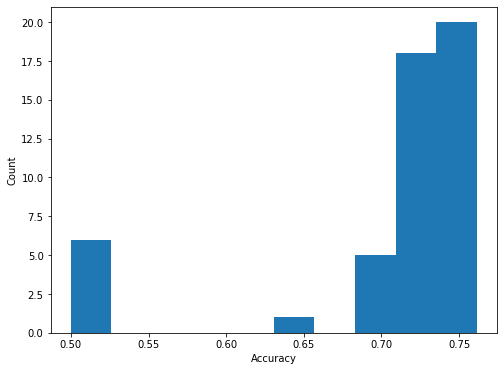

In [74]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [73]:
# 2nd try
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 70.8% and std: 6.5%


Text(0, 0.5, 'Count')

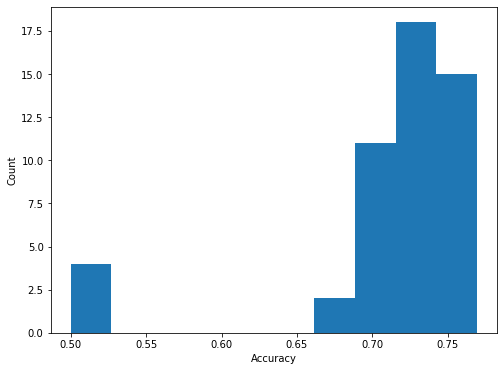

In [74]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [ ]:
# # # shuffle the data
# import random

# c = list(zip(graphs, labels))
# random.shuffle(c)

# graphs, labels = zip(*c)

In [ ]:
# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=10, n_repeats=5
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
#     print(f"\ntrain_index: \n{train_index}\ntest_index: \n{test_index}\n")
#     break
# print(f"train: {len(train_index)}, test: {len(test_index)}")

In [ ]:
type(graph_labels.iloc[train_index].values)

In [ ]:
graph_labels.iloc[test_index].values

In [ ]:
train_index.shape

In [69]:
train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=40, shuffle=False, seed=42)
test_gen = generator.flow(
    test_index, targets=graph_labels.iloc[test_index].values, batch_size=40, shuffle=False, seed=42)

In [70]:
model = create_graph_classification_model(generator)

history = model.fit(
        train_gen, epochs=200, validation_data=test_gen, verbose=1, callbacks=[es])

Epoch 1/200
18/18 [==============================] - 1s 44ms/step - loss: 0.4293 - acc: 0.8505 - val_loss: 0.7430 - val_acc: 0.5000
Epoch 2/200
18/18 [==============================] - 1s 35ms/step - loss: 0.3705 - acc: 0.8505 - val_loss: 0.6379 - val_acc: 0.5000
Epoch 3/200
18/18 [==============================] - 0s 21ms/step - loss: 0.3740 - acc: 0.8505 - val_loss: 0.6172 - val_acc: 0.5000
Epoch 4/200
18/18 [==============================] - 0s 24ms/step - loss: 0.3549 - acc: 0.8505 - val_loss: 0.7760 - val_acc: 0.5000
Epoch 5/200
18/18 [==============================] - 1s 30ms/step - loss: 0.3700 - acc: 0.8491 - val_loss: 0.6297 - val_acc: 0.5000
Epoch 6/200
18/18 [==============================] - 0s 20ms/step - loss: 0.3659 - acc: 0.8505 - val_loss: 0.6561 - val_acc: 0.5385
Epoch 7/200
18/18 [==============================] - 1s 40ms/step - loss: 0.3603 - acc: 0.8519 - val_loss: 0.8292 - val_acc: 0.5641
Epoch 8/200
18/18 [==============================] - 1s 31ms/step - loss: 0.

In [71]:
# calculate performance on the test data and return along with history
# Node features all 1, edge features all 1
test_metrics = model.evaluate(test_gen, verbose=1)
test_acc = test_metrics[model.metrics_names.index("acc")]

2/2 [==============================] - 0s 13ms/step - loss: 0.4897 - acc: 0.7564


In [72]:
# not_weighted
print(test_metrics)
#test loss, test acc: [0.5977194905281067, 0.6794871687889099]
# 2nd try: [0.6099531650543213, 0.7435897588729858]
# 3: [0.6134859919548035, 0.692307710647583]
# 4: [0.5708641409873962, 0.7564102411270142]
print(test_acc)

[0.48970162868499756, 0.7564102411270142]
0.7564102411270142


In [ ]:
print("Generate predictions for samples")
predictions = model.predict(test_gen, verbose=0)
print("predictions shape:", predictions.shape)
# predictions shape: (79, 1)
print(predictions)

[[0.9633641 ]
 [0.9572478 ]
 [0.92709166]
 [0.67149305]
 [0.75392646]
 [0.80909836]
 [0.8878052 ]
 [0.35882965]
 [0.8740735 ]
 [0.9488548 ]
 [0.71857995]
 [0.8417202 ]
 [0.77317935]
 [0.97507536]
 [0.7930052 ]
 [0.3096424 ]
 [0.81946105]
 [0.3233545 ]
 [0.75175   ]
 [0.79594046]
 [0.2881279 ]
 [0.42757368]
 [0.35783005]
 [0.53080255]
 [0.42272243]
 [0.8731016 ]
 [0.2651747 ]
 [0.9176288 ]
 [0.8412247 ]
 [0.84611094]
 [0.899879  ]
 [0.4730718 ]
 [0.6183011 ]
 [0.8530265 ]
 [0.38916534]
 [0.41842264]
 [0.90864706]
 [0.82059276]
 [0.89827585]
 [0.31872994]
 [0.9104121 ]
 [0.8878981 ]
 [0.4407365 ]
 [0.6909543 ]
 [0.75392646]
 [0.88234955]
 [0.75392646]
 [0.75392646]
 [0.2803172 ]
 [0.8783453 ]
 [0.6334169 ]
 [0.8953688 ]
 [0.9676844 ]
 [0.46171212]
 [0.42416874]
 [0.7234482 ]
 [0.93954104]
 [0.7739153 ]
 [0.37732255]
 [0.7243462 ]
 [0.975207  ]
 [0.39652586]
 [0.6909691 ]
 [0.75392646]
 [0.3582555 ]
 [0.75392646]
 [0.94787574]
 [0.47389334]
 [0.9733413 ]
 [0.75392646]
 [0.931447  ]
 [0.53550804]
 [0.31291372]
 [0.3546905 ]
 [0.75392646]
 [0.75392646]
 [0.3483727 ]
 [0.7502146 ]]

In [ ]:
print(test_gen.targets)

In [ ]:
print(temp_test)

In [ ]:
temp_test = np.array(test_gen.targets)

In [ ]:
print(y_pred)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_test = np.argmax(temp_test, axis=1) # Convert one-hot to index
y_pred = model.predict(test_gen)

print(classification_report(y_test, y_pred))